# 🤪 Variational Autoencoders - CelebA Faces

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Datasets

/content/drive/MyDrive/Datasets


In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
)

from scipy.stats import norm
import pandas as pd

from utils import sample_batch, display

from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces

## 0. Parameters <a name="parameters"></a>

In [4]:
%cd /content/drive/MyDrive/Datasets/lego_emoji

/content/drive/MyDrive/Datasets/lego_emoji


In [5]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 512
NUM_FEATURES = 64
Z_DIM = 100
LEARNING_RATE = 0.0005
EPOCHS = 250
BETA = 2500
LOAD_MODEL = False

## 1. Prepare the data <a name="prepare"></a>

In [6]:
# Load the data
train_data = utils.image_dataset_from_directory(
    "./lego+emoji",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 1994 files belonging to 1 classes.


In [7]:
# Preprocess the data
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img


train = train_data.map(lambda x: preprocess(x))

In [8]:
train_sample = sample_batch(train)

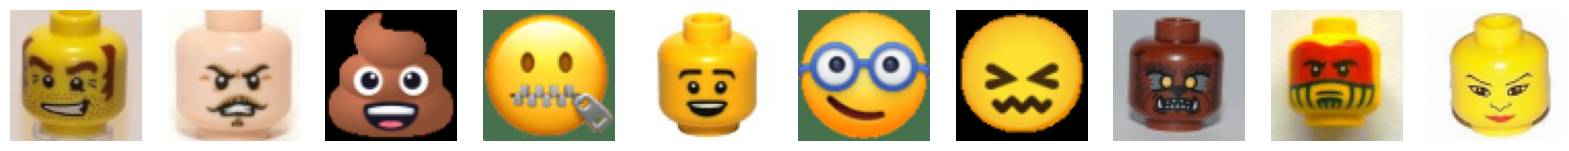

In [9]:
# Show some faces from the training set
display(train_sample, cmap=None)

## 2. Build the variational autoencoder <a name="build"></a>

In [10]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [11]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(
    encoder_input
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           1792      ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)           0         ['batch_normalization[0]

In [12]:
# Decoder
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 256)               25856     
                                                                 
 batch_normalization_5 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256)               0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 64)          36928     
 anspose)                                                    

In [13]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [14]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

## 3. Train the variational autoencoder <a name="train"></a>

In [15]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [16]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("./output/generated_img_%03d_%d.png" % (epoch, i))

In [17]:
# Load old weights if required
if LOAD_MODEL:
    vae.load_weights("./models/vae")
    tmp = vae.predict(train.take(1))

In [18]:
vae.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

Epoch 1/250
4/4 [==============================] - ETA: 0s - loss: 475.4727 - reconstruction_loss: 396.4342 - kl_loss: 48.6049

4/4 [==============================] - 74s 16s/step - loss: 469.3859 - reconstruction_loss: 396.4342 - kl_loss: 48.6049
Epoch 2/250
4/4 [==============================] - ETA: 0s - loss: 346.7461 - reconstruction_loss: 297.8034 - kl_loss: 33.5361

4/4 [==============================] - 16s 5s/step - loss: 343.6647 - reconstruction_loss: 297.8034 - kl_loss: 33.5361
Epoch 3/250
4/4 [==============================] - ETA: 0s - loss: 281.5790 - reconstruction_loss: 248.8762 - kl_loss: 25.7729

4/4 [==============================] - 17s 5s/step - loss: 280.1930 - reconstruction_loss: 248.8762 - kl_loss: 25.7729
Epoch 4/250
4/4 [==============================] - ETA: 0s - loss: 250.1238 - reconstruction_loss: 226.0935 - kl_loss: 18.7620

4/4 [==============================] - 17s 5s/step - loss: 249.0702 - reconstruction_loss: 226.0935 - kl_loss: 18.7620
Epoch 5/250
4/4 [==============================] - ETA: 0s - loss: 227.3202 - reconstruction_loss: 207.4287 - kl_loss: 15.4036

4/4 [==============================] - 18s 5s/step - loss: 226.4226 - reconstruction_loss: 207.4287 - kl_loss: 15.4036
Epoch 6/250
4/4 [==============================] - ETA: 0s - loss: 209.0351 - reconstruction_loss: 190.8184 - kl_loss: 13.5636

4/4 [==============================] - 16s 5s/step - loss: 208.1045 - reconstruction_loss: 190.8184 - kl_loss: 13.5636
Epoch 7/250
4/4 [==============================] - ETA: 0s - loss: 189.6504 - reconstruction_loss: 176.0285 - kl_loss: 13.0811

4/4 [==============================] - 17s 5s/step - loss: 189.5423 - reconstruction_loss: 176.0285 - kl_loss: 13.0811
Epoch 8/250
4/4 [==============================] - ETA: 0s - loss: 176.9303 - reconstruction_loss: 162.5988 - kl_loss: 13.5263

4/4 [==============================] - 17s 5s/step - loss: 176.7693 - reconstruction_loss: 162.5988 - kl_loss: 13.5263
Epoch 9/250
4/4 [==============================] - ETA: 0s - loss: 165.5719 - reconstruction_loss: 152.7486 - kl_loss: 12.8685

4/4 [==============================] - 17s 5s/step - loss: 165.5809 - reconstruction_loss: 152.7486 - kl_loss: 12.8685
Epoch 10/250
4/4 [==============================] - ETA: 0s - loss: 159.7748 - reconstruction_loss: 143.9933 - kl_loss: 12.6137

4/4 [==============================] - 17s 5s/step - loss: 159.1413 - reconstruction_loss: 143.9933 - kl_loss: 12.6137
Epoch 11/250
4/4 [==============================] - ETA: 0s - loss: 149.2862 - reconstruction_loss: 135.5505 - kl_loss: 13.5469

4/4 [==============================] - 17s 5s/step - loss: 149.2484 - reconstruction_loss: 135.5505 - kl_loss: 13.5469
Epoch 12/250
4/4 [==============================] - ETA: 0s - loss: 145.4814 - reconstruction_loss: 127.1703 - kl_loss: 13.9018

4/4 [==============================] - 16s 5s/step - loss: 144.5995 - reconstruction_loss: 127.1703 - kl_loss: 13.9018
Epoch 13/250
4/4 [==============================] - ETA: 0s - loss: 137.7429 - reconstruction_loss: 121.1640 - kl_loss: 14.3745

4/4 [==============================] - 17s 5s/step - loss: 137.3020 - reconstruction_loss: 121.1640 - kl_loss: 14.3745
Epoch 14/250
4/4 [==============================] - ETA: 0s - loss: 130.6739 - reconstruction_loss: 115.7493 - kl_loss: 15.0572

4/4 [==============================] - 16s 5s/step - loss: 130.7004 - reconstruction_loss: 115.7493 - kl_loss: 15.0572
Epoch 15/250
4/4 [==============================] - ETA: 0s - loss: 128.9844 - reconstruction_loss: 112.4560 - kl_loss: 14.8394

4/4 [==============================] - 16s 5s/step - loss: 128.6466 - reconstruction_loss: 112.4560 - kl_loss: 14.8394
Epoch 16/250
4/4 [==============================] - ETA: 0s - loss: 123.1061 - reconstruction_loss: 108.3201 - kl_loss: 15.2455

4/4 [==============================] - 17s 5s/step - loss: 123.1980 - reconstruction_loss: 108.3201 - kl_loss: 15.2455
Epoch 17/250
4/4 [==============================] - ETA: 0s - loss: 121.8477 - reconstruction_loss: 106.2904 - kl_loss: 15.0281

4/4 [==============================] - 17s 5s/step - loss: 121.7418 - reconstruction_loss: 106.2904 - kl_loss: 15.0281
Epoch 18/250
4/4 [==============================] - ETA: 0s - loss: 117.9334 - reconstruction_loss: 103.0962 - kl_loss: 15.3128

4/4 [==============================] - 18s 5s/step - loss: 118.0285 - reconstruction_loss: 103.0962 - kl_loss: 15.3128
Epoch 19/250
4/4 [==============================] - ETA: 0s - loss: 117.4477 - reconstruction_loss: 101.7081 - kl_loss: 15.1141

4/4 [==============================] - 16s 5s/step - loss: 117.3226 - reconstruction_loss: 101.7081 - kl_loss: 15.1141
Epoch 20/250
4/4 [==============================] - ETA: 0s - loss: 115.0526 - reconstruction_loss: 99.8119 - kl_loss: 15.3581 

4/4 [==============================] - 17s 5s/step - loss: 115.0760 - reconstruction_loss: 99.8119 - kl_loss: 15.3581
Epoch 21/250
4/4 [==============================] - ETA: 0s - loss: 113.5076 - reconstruction_loss: 97.2568 - kl_loss: 15.8238

4/4 [==============================] - 17s 5s/step - loss: 113.4222 - reconstruction_loss: 97.2568 - kl_loss: 15.8238
Epoch 22/250
4/4 [==============================] - ETA: 0s - loss: 111.4702 - reconstruction_loss: 96.2373 - kl_loss: 15.4985

4/4 [==============================] - 18s 5s/step - loss: 111.5233 - reconstruction_loss: 96.2373 - kl_loss: 15.4985
Epoch 23/250
4/4 [==============================] - ETA: 0s - loss: 110.1442 - reconstruction_loss: 95.6069 - kl_loss: 15.3776

4/4 [==============================] - 16s 5s/step - loss: 110.3122 - reconstruction_loss: 95.6069 - kl_loss: 15.3776
Epoch 24/250
4/4 [==============================] - ETA: 0s - loss: 109.7742 - reconstruction_loss: 93.5285 - kl_loss: 15.8806

4/4 [==============================] - 17s 5s/step - loss: 109.7011 - reconstruction_loss: 93.5285 - kl_loss: 15.8806
Epoch 25/250
4/4 [==============================] - ETA: 0s - loss: 108.7023 - reconstruction_loss: 93.0596 - kl_loss: 15.7237

4/4 [==============================] - 16s 5s/step - loss: 108.7185 - reconstruction_loss: 93.0596 - kl_loss: 15.7237
Epoch 26/250
4/4 [==============================] - ETA: 0s - loss: 107.3507 - reconstruction_loss: 91.2655 - kl_loss: 15.9764

4/4 [==============================] - 16s 5s/step - loss: 107.3289 - reconstruction_loss: 91.2655 - kl_loss: 15.9764
Epoch 27/250
4/4 [==============================] - ETA: 0s - loss: 106.7922 - reconstruction_loss: 91.0926 - kl_loss: 15.6245

4/4 [==============================] - 17s 5s/step - loss: 106.7772 - reconstruction_loss: 91.0926 - kl_loss: 15.6245
Epoch 28/250
4/4 [==============================] - ETA: 0s - loss: 105.1529 - reconstruction_loss: 90.0891 - kl_loss: 16.1810

4/4 [==============================] - 16s 5s/step - loss: 105.3763 - reconstruction_loss: 90.0891 - kl_loss: 16.1810
Epoch 29/250
4/4 [==============================] - ETA: 0s - loss: 104.7967 - reconstruction_loss: 88.8374 - kl_loss: 16.2271

4/4 [==============================] - 17s 5s/step - loss: 104.8503 - reconstruction_loss: 88.8374 - kl_loss: 16.2271
Epoch 30/250
4/4 [==============================] - ETA: 0s - loss: 105.5548 - reconstruction_loss: 88.9630 - kl_loss: 16.0815

4/4 [==============================] - 16s 5s/step - loss: 105.4528 - reconstruction_loss: 88.9630 - kl_loss: 16.0815
Epoch 31/250
4/4 [==============================] - ETA: 0s - loss: 103.3905 - reconstruction_loss: 87.5109 - kl_loss: 16.6934

4/4 [==============================] - 16s 5s/step - loss: 103.5533 - reconstruction_loss: 87.5109 - kl_loss: 16.6934
Epoch 32/250
4/4 [==============================] - ETA: 0s - loss: 103.0827 - reconstruction_loss: 87.4009 - kl_loss: 16.2766

4/4 [==============================] - 17s 5s/step - loss: 103.2016 - reconstruction_loss: 87.4009 - kl_loss: 16.2766
Epoch 33/250
4/4 [==============================] - ETA: 0s - loss: 103.9414 - reconstruction_loss: 86.5068 - kl_loss: 16.6815

4/4 [==============================] - 17s 5s/step - loss: 103.7908 - reconstruction_loss: 86.5068 - kl_loss: 16.6815
Epoch 34/250
4/4 [==============================] - ETA: 0s - loss: 102.0241 - reconstruction_loss: 85.7086 - kl_loss: 16.6079

4/4 [==============================] - 16s 5s/step - loss: 102.0825 - reconstruction_loss: 85.7086 - kl_loss: 16.6079
Epoch 35/250
4/4 [==============================] - 11s 3s/step - loss: 102.5452 - reconstruction_loss: 85.7461 - kl_loss: 16.5961
Epoch 36/250
4/4 [==============================] - ETA: 0s - loss: 100.8862 - reconstruction_loss: 84.1914 - kl_loss: 16.8269

4/4 [==============================] - 16s 5s/step - loss: 100.9126 - reconstruction_loss: 84.1914 - kl_loss: 16.8269
Epoch 37/250
4/4 [==============================] - ETA: 0s - loss: 99.8879 - reconstruction_loss: 83.7114 - kl_loss: 17.0731

4/4 [==============================] - 17s 5s/step - loss: 100.0672 - reconstruction_loss: 83.7114 - kl_loss: 17.0731
Epoch 38/250
4/4 [==============================] - ETA: 0s - loss: 101.1111 - reconstruction_loss: 83.6339 - kl_loss: 16.5551

4/4 [==============================] - 17s 5s/step - loss: 100.9266 - reconstruction_loss: 83.6339 - kl_loss: 16.5551
Epoch 39/250
4/4 [==============================] - ETA: 0s - loss: 99.8950 - reconstruction_loss: 82.9661 - kl_loss: 16.9220

4/4 [==============================] - 17s 5s/step - loss: 99.8936 - reconstruction_loss: 82.9661 - kl_loss: 16.9220
Epoch 40/250
4/4 [==============================] - ETA: 0s - loss: 98.8967 - reconstruction_loss: 81.9918 - kl_loss: 16.8984

4/4 [==============================] - 16s 5s/step - loss: 98.8955 - reconstruction_loss: 81.9918 - kl_loss: 16.8984
Epoch 41/250
4/4 [==============================] - 11s 3s/step - loss: 98.9999 - reconstruction_loss: 82.3541 - kl_loss: 16.7595
Epoch 42/250
4/4 [==============================] - ETA: 0s - loss: 99.0187 - reconstruction_loss: 80.9094 - kl_loss: 17.4295

4/4 [==============================] - 17s 5s/step - loss: 98.8828 - reconstruction_loss: 80.9094 - kl_loss: 17.4295
Epoch 43/250
4/4 [==============================] - ETA: 0s - loss: 98.6168 - reconstruction_loss: 81.0500 - kl_loss: 16.9051

4/4 [==============================] - 16s 5s/step - loss: 98.4845 - reconstruction_loss: 81.0500 - kl_loss: 16.9051
Epoch 44/250
4/4 [==============================] - ETA: 0s - loss: 97.7481 - reconstruction_loss: 80.9909 - kl_loss: 16.8078

4/4 [==============================] - 18s 5s/step - loss: 97.7583 - reconstruction_loss: 80.9909 - kl_loss: 16.8078
Epoch 45/250
4/4 [==============================] - ETA: 0s - loss: 96.7495 - reconstruction_loss: 80.4382 - kl_loss: 16.7781

4/4 [==============================] - 16s 5s/step - loss: 96.8429 - reconstruction_loss: 80.4382 - kl_loss: 16.7781
Epoch 46/250
4/4 [==============================] - 11s 3s/step - loss: 97.4283 - reconstruction_loss: 80.0860 - kl_loss: 17.1832
Epoch 47/250
4/4 [==============================] - ETA: 0s - loss: 96.7560 - reconstruction_loss: 79.1398 - kl_loss: 17.3615

4/4 [==============================] - 16s 5s/step - loss: 96.7051 - reconstruction_loss: 79.1398 - kl_loss: 17.3615
Epoch 48/250
4/4 [==============================] - ETA: 0s - loss: 97.4797 - reconstruction_loss: 79.4046 - kl_loss: 17.0287

4/4 [==============================] - 16s 5s/step - loss: 97.2704 - reconstruction_loss: 79.4046 - kl_loss: 17.0287
Epoch 49/250
4/4 [==============================] - ETA: 0s - loss: 97.1043 - reconstruction_loss: 78.8694 - kl_loss: 17.3074

4/4 [==============================] - 16s 5s/step - loss: 96.9188 - reconstruction_loss: 78.8694 - kl_loss: 17.3074
Epoch 50/250
4/4 [==============================] - 11s 3s/step - loss: 96.4007 - reconstruction_loss: 79.2937 - kl_loss: 17.1165
Epoch 51/250
4/4 [==============================] - ETA: 0s - loss: 95.5592 - reconstruction_loss: 77.7900 - kl_loss: 17.4415

4/4 [==============================] - 16s 5s/step - loss: 95.4936 - reconstruction_loss: 77.7900 - kl_loss: 17.4415
Epoch 52/250
4/4 [==============================] - ETA: 0s - loss: 95.5296 - reconstruction_loss: 77.8677 - kl_loss: 17.2061

4/4 [==============================] - 16s 5s/step - loss: 95.4385 - reconstruction_loss: 77.8677 - kl_loss: 17.2061
Epoch 53/250
4/4 [==============================] - ETA: 0s - loss: 93.8621 - reconstruction_loss: 76.7936 - kl_loss: 17.3268

4/4 [==============================] - 17s 5s/step - loss: 93.9138 - reconstruction_loss: 76.7936 - kl_loss: 17.3268
Epoch 54/250
4/4 [==============================] - 11s 3s/step - loss: 94.8483 - reconstruction_loss: 77.5580 - kl_loss: 17.0585
Epoch 55/250
4/4 [==============================] - 11s 3s/step - loss: 95.0435 - reconstruction_loss: 76.9673 - kl_loss: 17.2427
Epoch 56/250
4/4 [==============================] - ETA: 0s - loss: 94.0720 - reconstruction_loss: 76.6615 - kl_loss: 17.0110

4/4 [==============================] - 16s 5s/step - loss: 93.9921 - reconstruction_loss: 76.6615 - kl_loss: 17.0110
Epoch 57/250
4/4 [==============================] - ETA: 0s - loss: 92.7374 - reconstruction_loss: 75.9270 - kl_loss: 17.3371

4/4 [==============================] - 16s 5s/step - loss: 92.8428 - reconstruction_loss: 75.9270 - kl_loss: 17.3371
Epoch 58/250
4/4 [==============================] - ETA: 0s - loss: 94.3567 - reconstruction_loss: 75.8366 - kl_loss: 17.1783

4/4 [==============================] - 17s 5s/step - loss: 94.0883 - reconstruction_loss: 75.8366 - kl_loss: 17.1783
Epoch 59/250
4/4 [==============================] - ETA: 0s - loss: 93.1228 - reconstruction_loss: 75.8648 - kl_loss: 17.0735

4/4 [==============================] - 17s 5s/step - loss: 93.0859 - reconstruction_loss: 75.8648 - kl_loss: 17.0735
Epoch 60/250
4/4 [==============================] - ETA: 0s - loss: 92.6930 - reconstruction_loss: 75.2529 - kl_loss: 17.2797

4/4 [==============================] - 17s 5s/step - loss: 92.6609 - reconstruction_loss: 75.2529 - kl_loss: 17.2797
Epoch 61/250
4/4 [==============================] - 11s 3s/step - loss: 92.7323 - reconstruction_loss: 75.6258 - kl_loss: 17.0109
Epoch 62/250
4/4 [==============================] - ETA: 0s - loss: 92.7844 - reconstruction_loss: 74.6647 - kl_loss: 17.3745

4/4 [==============================] - 17s 5s/step - loss: 92.6354 - reconstruction_loss: 74.6647 - kl_loss: 17.3745
Epoch 63/250
4/4 [==============================] - ETA: 0s - loss: 90.7687 - reconstruction_loss: 74.5763 - kl_loss: 16.9357

4/4 [==============================] - 17s 5s/step - loss: 90.9173 - reconstruction_loss: 74.5763 - kl_loss: 16.9357
Epoch 64/250
4/4 [==============================] - ETA: 0s - loss: 90.8455 - reconstruction_loss: 74.3117 - kl_loss: 17.1164

4/4 [==============================] - 16s 5s/step - loss: 90.9620 - reconstruction_loss: 74.3117 - kl_loss: 17.1164
Epoch 65/250
4/4 [==============================] - 11s 3s/step - loss: 91.5260 - reconstruction_loss: 74.3324 - kl_loss: 17.1390
Epoch 66/250
4/4 [==============================] - ETA: 0s - loss: 90.9072 - reconstruction_loss: 73.7818 - kl_loss: 17.1961

4/4 [==============================] - 17s 5s/step - loss: 90.9213 - reconstruction_loss: 73.7818 - kl_loss: 17.1961
Epoch 67/250
4/4 [==============================] - ETA: 0s - loss: 90.8875 - reconstruction_loss: 73.3337 - kl_loss: 17.0469

4/4 [==============================] - 18s 5s/step - loss: 90.7861 - reconstruction_loss: 73.3337 - kl_loss: 17.0469
Epoch 68/250
4/4 [==============================] - 12s 3s/step - loss: 90.5280 - reconstruction_loss: 73.4294 - kl_loss: 16.9546
Epoch 69/250
4/4 [==============================] - ETA: 0s - loss: 89.7875 - reconstruction_loss: 72.9577 - kl_loss: 17.0003

4/4 [==============================] - 17s 5s/step - loss: 89.8216 - reconstruction_loss: 72.9577 - kl_loss: 17.0003
Epoch 70/250
4/4 [==============================] - 13s 3s/step - loss: 89.9118 - reconstruction_loss: 73.0737 - kl_loss: 16.8976
Epoch 71/250
4/4 [==============================] - ETA: 0s - loss: 89.7627 - reconstruction_loss: 72.4600 - kl_loss: 17.0075

4/4 [==============================] - 17s 5s/step - loss: 89.7037 - reconstruction_loss: 72.4600 - kl_loss: 17.0075
Epoch 72/250
4/4 [==============================] - ETA: 0s - loss: 90.1048 - reconstruction_loss: 72.2366 - kl_loss: 17.1355

4/4 [==============================] - 16s 5s/step - loss: 89.9583 - reconstruction_loss: 72.2366 - kl_loss: 17.1355
Epoch 73/250
4/4 [==============================] - ETA: 0s - loss: 89.0498 - reconstruction_loss: 71.5859 - kl_loss: 17.0780

4/4 [==============================] - 16s 5s/step - loss: 88.9726 - reconstruction_loss: 71.5859 - kl_loss: 17.0780
Epoch 74/250
4/4 [==============================] - 11s 3s/step - loss: 89.1336 - reconstruction_loss: 72.3356 - kl_loss: 16.6578
Epoch 75/250
4/4 [==============================] - 11s 3s/step - loss: 88.7262 - reconstruction_loss: 71.9039 - kl_loss: 16.8782
Epoch 76/250
4/4 [==============================] - ETA: 0s - loss: 89.6117 - reconstruction_loss: 71.4459 - kl_loss: 16.8850

4/4 [==============================] - 17s 5s/step - loss: 89.3556 - reconstruction_loss: 71.4459 - kl_loss: 16.8850
Epoch 77/250
4/4 [==============================] - 11s 3s/step - loss: 89.4664 - reconstruction_loss: 71.5725 - kl_loss: 17.0372
Epoch 78/250
4/4 [==============================] - ETA: 0s - loss: 87.1042 - reconstruction_loss: 70.6681 - kl_loss: 16.9229

4/4 [==============================] - 17s 5s/step - loss: 87.2015 - reconstruction_loss: 70.6681 - kl_loss: 16.9229
Epoch 79/250
4/4 [==============================] - ETA: 0s - loss: 87.1210 - reconstruction_loss: 70.6654 - kl_loss: 16.6671

4/4 [==============================] - 17s 5s/step - loss: 87.1633 - reconstruction_loss: 70.6654 - kl_loss: 16.6671
Epoch 80/250
4/4 [==============================] - ETA: 0s - loss: 86.7293 - reconstruction_loss: 70.6289 - kl_loss: 16.6829

4/4 [==============================] - 16s 5s/step - loss: 86.8458 - reconstruction_loss: 70.6289 - kl_loss: 16.6829
Epoch 81/250
4/4 [==============================] - 11s 3s/step - loss: 86.8158 - reconstruction_loss: 70.7672 - kl_loss: 16.6269
Epoch 82/250
4/4 [==============================] - ETA: 0s - loss: 86.4069 - reconstruction_loss: 69.6835 - kl_loss: 16.8262

4/4 [==============================] - 17s 5s/step - loss: 86.4275 - reconstruction_loss: 69.6835 - kl_loss: 16.8262
Epoch 83/250
4/4 [==============================] - ETA: 0s - loss: 85.6579 - reconstruction_loss: 69.7097 - kl_loss: 16.5386

4/4 [==============================] - 16s 5s/step - loss: 85.7760 - reconstruction_loss: 69.7097 - kl_loss: 16.5386
Epoch 84/250
4/4 [==============================] - 11s 3s/step - loss: 86.1072 - reconstruction_loss: 69.8495 - kl_loss: 16.6562
Epoch 85/250
4/4 [==============================] - ETA: 0s - loss: 86.5306 - reconstruction_loss: 69.2019 - kl_loss: 16.8206

4/4 [==============================] - 17s 5s/step - loss: 86.4290 - reconstruction_loss: 69.2019 - kl_loss: 16.8206
Epoch 86/250
4/4 [==============================] - 11s 3s/step - loss: 85.9828 - reconstruction_loss: 69.3043 - kl_loss: 16.8577
Epoch 87/250
4/4 [==============================] - ETA: 0s - loss: 86.0003 - reconstruction_loss: 68.8736 - kl_loss: 16.8201

4/4 [==============================] - 17s 5s/step - loss: 85.9390 - reconstruction_loss: 68.8736 - kl_loss: 16.8201
Epoch 88/250
4/4 [==============================] - 12s 3s/step - loss: 84.4677 - reconstruction_loss: 69.1211 - kl_loss: 16.5822
Epoch 89/250
4/4 [==============================] - ETA: 0s - loss: 86.8665 - reconstruction_loss: 69.1817 - kl_loss: 16.4841

4/4 [==============================] - 17s 5s/step - loss: 86.6264 - reconstruction_loss: 69.1817 - kl_loss: 16.4841
Epoch 90/250
4/4 [==============================] - ETA: 0s - loss: 84.1362 - reconstruction_loss: 68.2181 - kl_loss: 16.4259

4/4 [==============================] - 17s 5s/step - loss: 84.2378 - reconstruction_loss: 68.2181 - kl_loss: 16.4259
Epoch 91/250
4/4 [==============================] - 11s 3s/step - loss: 84.2629 - reconstruction_loss: 68.4032 - kl_loss: 16.5094
Epoch 92/250
4/4 [==============================] - 11s 3s/step - loss: 84.6518 - reconstruction_loss: 68.7352 - kl_loss: 16.3055
Epoch 93/250
4/4 [==============================] - ETA: 0s - loss: 84.4538 - reconstruction_loss: 67.7429 - kl_loss: 16.5087

4/4 [==============================] - 17s 5s/step - loss: 84.4134 - reconstruction_loss: 67.7429 - kl_loss: 16.5087
Epoch 94/250
4/4 [==============================] - 11s 3s/step - loss: 84.6967 - reconstruction_loss: 68.4145 - kl_loss: 16.2668
Epoch 95/250
4/4 [==============================] - 11s 3s/step - loss: 83.9845 - reconstruction_loss: 67.6943 - kl_loss: 16.6885
Epoch 96/250
4/4 [==============================] - ETA: 0s - loss: 83.7485 - reconstruction_loss: 67.2049 - kl_loss: 16.5561

4/4 [==============================] - 17s 5s/step - loss: 83.7510 - reconstruction_loss: 67.2049 - kl_loss: 16.5561
Epoch 97/250
4/4 [==============================] - 11s 3s/step - loss: 83.8398 - reconstruction_loss: 67.6533 - kl_loss: 16.4743
Epoch 98/250
4/4 [==============================] - ETA: 0s - loss: 83.4294 - reconstruction_loss: 67.2224 - kl_loss: 16.2723

4/4 [==============================] - 16s 5s/step - loss: 83.4425 - reconstruction_loss: 67.2224 - kl_loss: 16.2723
Epoch 99/250
4/4 [==============================] - ETA: 0s - loss: 83.3527 - reconstruction_loss: 66.6796 - kl_loss: 16.4193

4/4 [==============================] - 17s 5s/step - loss: 83.3019 - reconstruction_loss: 66.6796 - kl_loss: 16.4193
Epoch 100/250
4/4 [==============================] - ETA: 0s - loss: 82.6608 - reconstruction_loss: 66.7636 - kl_loss: 16.2385

4/4 [==============================] - 17s 5s/step - loss: 82.7290 - reconstruction_loss: 66.7636 - kl_loss: 16.2385
Epoch 101/250
4/4 [==============================] - ETA: 0s - loss: 83.3157 - reconstruction_loss: 66.4605 - kl_loss: 16.2088

4/4 [==============================] - 17s 5s/step - loss: 83.1865 - reconstruction_loss: 66.4605 - kl_loss: 16.2088
Epoch 102/250
4/4 [==============================] - ETA: 0s - loss: 83.5563 - reconstruction_loss: 66.3164 - kl_loss: 16.2169

4/4 [==============================] - 18s 5s/step - loss: 83.3517 - reconstruction_loss: 66.3164 - kl_loss: 16.2169
Epoch 103/250
4/4 [==============================] - 13s 4s/step - loss: 82.4729 - reconstruction_loss: 66.5254 - kl_loss: 16.2193
Epoch 104/250
4/4 [==============================] - ETA: 0s - loss: 81.8471 - reconstruction_loss: 66.1349 - kl_loss: 16.1263

4/4 [==============================] - 17s 5s/step - loss: 81.9299 - reconstruction_loss: 66.1349 - kl_loss: 16.1263
Epoch 105/250
4/4 [==============================] - ETA: 0s - loss: 81.5792 - reconstruction_loss: 65.9939 - kl_loss: 16.1478

4/4 [==============================] - 17s 5s/step - loss: 81.6917 - reconstruction_loss: 65.9939 - kl_loss: 16.1478
Epoch 106/250
4/4 [==============================] - 12s 3s/step - loss: 82.1689 - reconstruction_loss: 66.2529 - kl_loss: 16.2535
Epoch 107/250
4/4 [==============================] - ETA: 0s - loss: 81.9929 - reconstruction_loss: 65.6691 - kl_loss: 16.2251

4/4 [==============================] - 17s 5s/step - loss: 81.9732 - reconstruction_loss: 65.6691 - kl_loss: 16.2251
Epoch 108/250
4/4 [==============================] - 11s 3s/step - loss: 81.4971 - reconstruction_loss: 65.8998 - kl_loss: 16.0987
Epoch 109/250
4/4 [==============================] - ETA: 0s - loss: 80.4501 - reconstruction_loss: 65.3965 - kl_loss: 16.1850

4/4 [==============================] - 17s 5s/step - loss: 80.6763 - reconstruction_loss: 65.3965 - kl_loss: 16.1850
Epoch 110/250
4/4 [==============================] - ETA: 0s - loss: 81.7095 - reconstruction_loss: 65.1716 - kl_loss: 16.2116

4/4 [==============================] - 16s 5s/step - loss: 81.6442 - reconstruction_loss: 65.1716 - kl_loss: 16.2116
Epoch 111/250
4/4 [==============================] - ETA: 0s - loss: 81.1814 - reconstruction_loss: 65.0511 - kl_loss: 16.0814

4/4 [==============================] - 17s 5s/step - loss: 81.1716 - reconstruction_loss: 65.0511 - kl_loss: 16.0814
Epoch 112/250
4/4 [==============================] - 11s 3s/step - loss: 82.9516 - reconstruction_loss: 65.9242 - kl_loss: 16.1470
Epoch 113/250
4/4 [==============================] - ETA: 0s - loss: 80.9948 - reconstruction_loss: 64.8539 - kl_loss: 16.2663

4/4 [==============================] - 17s 5s/step - loss: 81.0199 - reconstruction_loss: 64.8539 - kl_loss: 16.2663
Epoch 114/250
4/4 [==============================] - ETA: 0s - loss: 79.0385 - reconstruction_loss: 64.7997 - kl_loss: 15.9980

4/4 [==============================] - 18s 5s/step - loss: 79.3903 - reconstruction_loss: 64.7997 - kl_loss: 15.9980
Epoch 115/250
4/4 [==============================] - ETA: 0s - loss: 80.0487 - reconstruction_loss: 64.8217 - kl_loss: 15.9704

4/4 [==============================] - 16s 5s/step - loss: 80.1974 - reconstruction_loss: 64.8217 - kl_loss: 15.9704
Epoch 116/250
4/4 [==============================] - ETA: 0s - loss: 79.7022 - reconstruction_loss: 64.3341 - kl_loss: 16.0348

4/4 [==============================] - 17s 5s/step - loss: 79.8356 - reconstruction_loss: 64.3341 - kl_loss: 16.0348
Epoch 117/250
4/4 [==============================] - 12s 3s/step - loss: 80.9177 - reconstruction_loss: 64.3651 - kl_loss: 16.0645
Epoch 118/250
4/4 [==============================] - 11s 3s/step - loss: 80.0327 - reconstruction_loss: 64.2400 - kl_loss: 16.1383
Epoch 119/250
4/4 [==============================] - ETA: 0s - loss: 79.3677 - reconstruction_loss: 63.8507 - kl_loss: 16.0829

4/4 [==============================] - 18s 5s/step - loss: 79.4809 - reconstruction_loss: 63.8507 - kl_loss: 16.0829
Epoch 120/250
4/4 [==============================] - 12s 3s/step - loss: 79.7211 - reconstruction_loss: 64.3095 - kl_loss: 16.0502
Epoch 121/250
4/4 [==============================] - ETA: 0s - loss: 78.9937 - reconstruction_loss: 63.8323 - kl_loss: 15.8794

4/4 [==============================] - 16s 5s/step - loss: 79.1373 - reconstruction_loss: 63.8323 - kl_loss: 15.8794
Epoch 122/250
4/4 [==============================] - ETA: 0s - loss: 79.9690 - reconstruction_loss: 63.6224 - kl_loss: 15.9159

4/4 [==============================] - 17s 5s/step - loss: 79.8828 - reconstruction_loss: 63.6224 - kl_loss: 15.9159
Epoch 123/250
4/4 [==============================] - ETA: 0s - loss: 79.2170 - reconstruction_loss: 63.2852 - kl_loss: 16.0304

4/4 [==============================] - 17s 5s/step - loss: 79.2367 - reconstruction_loss: 63.2852 - kl_loss: 16.0304
Epoch 124/250
4/4 [==============================] - 12s 3s/step - loss: 78.9714 - reconstruction_loss: 63.5204 - kl_loss: 15.9131
Epoch 125/250
4/4 [==============================] - 11s 3s/step - loss: 79.4747 - reconstruction_loss: 63.5572 - kl_loss: 15.8751
Epoch 126/250
4/4 [==============================] - 11s 3s/step - loss: 78.8532 - reconstruction_loss: 63.5359 - kl_loss: 15.8565
Epoch 127/250
4/4 [==============================] - ETA: 0s - loss: 78.5853 - reconstruction_loss: 63.0916 - kl_loss: 16.0026

4/4 [==============================] - 17s 5s/step - loss: 78.6871 - reconstruction_loss: 63.0916 - kl_loss: 16.0026
Epoch 128/250
4/4 [==============================] - ETA: 0s - loss: 77.6658 - reconstruction_loss: 62.9085 - kl_loss: 16.0570

4/4 [==============================] - 18s 5s/step - loss: 77.9258 - reconstruction_loss: 62.9085 - kl_loss: 16.0570
Epoch 129/250
4/4 [==============================] - ETA: 0s - loss: 78.6476 - reconstruction_loss: 62.8128 - kl_loss: 15.9015

4/4 [==============================] - 16s 5s/step - loss: 78.6610 - reconstruction_loss: 62.8128 - kl_loss: 15.9015
Epoch 130/250
4/4 [==============================] - ETA: 0s - loss: 77.8400 - reconstruction_loss: 62.8015 - kl_loss: 15.7707

4/4 [==============================] - 17s 5s/step - loss: 77.9865 - reconstruction_loss: 62.8015 - kl_loss: 15.7707
Epoch 131/250
4/4 [==============================] - ETA: 0s - loss: 79.3141 - reconstruction_loss: 62.4414 - kl_loss: 15.8891

4/4 [==============================] - 17s 5s/step - loss: 79.1174 - reconstruction_loss: 62.4414 - kl_loss: 15.8891
Epoch 132/250
4/4 [==============================] - ETA: 0s - loss: 77.5798 - reconstruction_loss: 62.1801 - kl_loss: 15.8188

4/4 [==============================] - 17s 5s/step - loss: 77.6637 - reconstruction_loss: 62.1801 - kl_loss: 15.8188
Epoch 133/250
4/4 [==============================] - 11s 3s/step - loss: 78.3049 - reconstruction_loss: 62.3905 - kl_loss: 15.7018
Epoch 134/250
4/4 [==============================] - 11s 3s/step - loss: 77.8052 - reconstruction_loss: 62.2356 - kl_loss: 15.8140
Epoch 135/250
4/4 [==============================] - ETA: 0s - loss: 78.2439 - reconstruction_loss: 61.8900 - kl_loss: 15.8089

4/4 [==============================] - 16s 5s/step - loss: 78.1349 - reconstruction_loss: 61.8900 - kl_loss: 15.8089
Epoch 136/250
4/4 [==============================] - 12s 3s/step - loss: 77.0329 - reconstruction_loss: 62.0124 - kl_loss: 15.7319
Epoch 137/250
4/4 [==============================] - ETA: 0s - loss: 77.7299 - reconstruction_loss: 61.8015 - kl_loss: 15.6290

4/4 [==============================] - 17s 5s/step - loss: 77.6701 - reconstruction_loss: 61.8015 - kl_loss: 15.6290
Epoch 138/250
4/4 [==============================] - 11s 3s/step - loss: 78.4067 - reconstruction_loss: 62.3765 - kl_loss: 15.6537
Epoch 139/250
4/4 [==============================] - ETA: 0s - loss: 77.5309 - reconstruction_loss: 61.4940 - kl_loss: 15.7953

4/4 [==============================] - 18s 5s/step - loss: 77.4826 - reconstruction_loss: 61.4940 - kl_loss: 15.7953
Epoch 140/250
4/4 [==============================] - 12s 3s/step - loss: 76.5980 - reconstruction_loss: 61.7635 - kl_loss: 15.7895
Epoch 141/250
4/4 [==============================] - 11s 3s/step - loss: 76.3589 - reconstruction_loss: 61.6333 - kl_loss: 15.7510
Epoch 142/250
4/4 [==============================] - ETA: 0s - loss: 77.0202 - reconstruction_loss: 61.2563 - kl_loss: 15.8411

4/4 [==============================] - 16s 5s/step - loss: 77.0356 - reconstruction_loss: 61.2563 - kl_loss: 15.8411
Epoch 143/250
4/4 [==============================] - ETA: 0s - loss: 76.0769 - reconstruction_loss: 61.3296 - kl_loss: 15.7439

4/4 [==============================] - 17s 5s/step - loss: 76.2762 - reconstruction_loss: 61.3296 - kl_loss: 15.7439
Epoch 144/250
4/4 [==============================] - ETA: 0s - loss: 76.5725 - reconstruction_loss: 61.2145 - kl_loss: 15.8008

4/4 [==============================] - 16s 5s/step - loss: 76.6611 - reconstruction_loss: 61.2145 - kl_loss: 15.8008
Epoch 145/250
4/4 [==============================] - ETA: 0s - loss: 76.6683 - reconstruction_loss: 61.1680 - kl_loss: 15.5935

4/4 [==============================] - 18s 5s/step - loss: 76.6870 - reconstruction_loss: 61.1680 - kl_loss: 15.5935
Epoch 146/250
4/4 [==============================] - 11s 3s/step - loss: 77.5383 - reconstruction_loss: 61.2129 - kl_loss: 15.6274
Epoch 147/250
4/4 [==============================] - ETA: 0s - loss: 76.6138 - reconstruction_loss: 60.7391 - kl_loss: 15.7923

4/4 [==============================] - 16s 5s/step - loss: 76.5973 - reconstruction_loss: 60.7391 - kl_loss: 15.7923
Epoch 148/250
4/4 [==============================] - 11s 3s/step - loss: 76.5765 - reconstruction_loss: 60.9877 - kl_loss: 15.6346
Epoch 149/250
4/4 [==============================] - 11s 3s/step - loss: 76.8596 - reconstruction_loss: 60.9642 - kl_loss: 15.7686
Epoch 150/250
4/4 [==============================] - 11s 3s/step - loss: 76.5451 - reconstruction_loss: 60.8900 - kl_loss: 15.6888
Epoch 151/250
4/4 [==============================] - ETA: 0s - loss: 75.8958 - reconstruction_loss: 60.5051 - kl_loss: 15.6264

4/4 [==============================] - 16s 5s/step - loss: 75.9430 - reconstruction_loss: 60.5051 - kl_loss: 15.6264
Epoch 152/250
4/4 [==============================] - ETA: 0s - loss: 76.0486 - reconstruction_loss: 60.4935 - kl_loss: 15.5939

4/4 [==============================] - 16s 5s/step - loss: 76.0563 - reconstruction_loss: 60.4935 - kl_loss: 15.5939
Epoch 153/250
4/4 [==============================] - 11s 3s/step - loss: 76.8260 - reconstruction_loss: 60.6850 - kl_loss: 15.5340
Epoch 154/250
4/4 [==============================] - ETA: 0s - loss: 75.5974 - reconstruction_loss: 60.0075 - kl_loss: 15.7476

4/4 [==============================] - 17s 5s/step - loss: 75.6289 - reconstruction_loss: 60.0075 - kl_loss: 15.7476
Epoch 155/250
4/4 [==============================] - ETA: 0s - loss: 75.9389 - reconstruction_loss: 60.0678 - kl_loss: 15.6191

4/4 [==============================] - 17s 5s/step - loss: 75.8885 - reconstruction_loss: 60.0678 - kl_loss: 15.6191
Epoch 156/250
4/4 [==============================] - 11s 3s/step - loss: 75.6606 - reconstruction_loss: 60.4395 - kl_loss: 15.5321
Epoch 157/250
4/4 [==============================] - 11s 3s/step - loss: 75.6432 - reconstruction_loss: 60.1062 - kl_loss: 15.6719
Epoch 158/250
4/4 [==============================] - ETA: 0s - loss: 76.3074 - reconstruction_loss: 59.7380 - kl_loss: 15.6489

4/4 [==============================] - 17s 5s/step - loss: 76.1233 - reconstruction_loss: 59.7380 - kl_loss: 15.6489
Epoch 159/250
4/4 [==============================] - 11s 3s/step - loss: 76.2365 - reconstruction_loss: 59.8055 - kl_loss: 15.6196
Epoch 160/250
4/4 [==============================] - 11s 3s/step - loss: 75.7016 - reconstruction_loss: 59.8992 - kl_loss: 15.6790
Epoch 161/250
4/4 [==============================] - ETA: 0s - loss: 74.9118 - reconstruction_loss: 59.6424 - kl_loss: 15.6242

4/4 [==============================] - 19s 6s/step - loss: 74.9828 - reconstruction_loss: 59.6424 - kl_loss: 15.6242
Epoch 162/250
4/4 [==============================] - ETA: 0s - loss: 74.4927 - reconstruction_loss: 59.6870 - kl_loss: 15.5605

4/4 [==============================] - 16s 5s/step - loss: 74.6437 - reconstruction_loss: 59.6870 - kl_loss: 15.5605
Epoch 163/250
4/4 [==============================] - ETA: 0s - loss: 75.0904 - reconstruction_loss: 59.2099 - kl_loss: 15.5118

4/4 [==============================] - 17s 5s/step - loss: 75.0167 - reconstruction_loss: 59.2099 - kl_loss: 15.5118
Epoch 164/250
4/4 [==============================] - 11s 3s/step - loss: 74.4859 - reconstruction_loss: 59.8280 - kl_loss: 15.4049
Epoch 165/250
4/4 [==============================] - ETA: 0s - loss: 74.1964 - reconstruction_loss: 58.9786 - kl_loss: 15.5816

4/4 [==============================] - 18s 5s/step - loss: 74.2691 - reconstruction_loss: 58.9786 - kl_loss: 15.5816
Epoch 166/250
4/4 [==============================] - 11s 3s/step - loss: 75.2156 - reconstruction_loss: 59.6464 - kl_loss: 15.3962
Epoch 167/250
4/4 [==============================] - 12s 3s/step - loss: 74.2638 - reconstruction_loss: 59.0885 - kl_loss: 15.4917
Epoch 168/250
4/4 [==============================] - ETA: 0s - loss: 74.1461 - reconstruction_loss: 59.0372 - kl_loss: 15.4964

4/4 [==============================] - 17s 5s/step - loss: 74.2236 - reconstruction_loss: 59.0372 - kl_loss: 15.4964
Epoch 169/250
4/4 [==============================] - 11s 3s/step - loss: 74.3876 - reconstruction_loss: 59.1161 - kl_loss: 15.5493
Epoch 170/250
4/4 [==============================] - 11s 3s/step - loss: 75.2210 - reconstruction_loss: 58.9516 - kl_loss: 15.5923
Epoch 171/250
4/4 [==============================] - ETA: 0s - loss: 73.9664 - reconstruction_loss: 58.7036 - kl_loss: 15.5044

4/4 [==============================] - 17s 5s/step - loss: 74.0147 - reconstruction_loss: 58.7036 - kl_loss: 15.5044
Epoch 172/250
4/4 [==============================] - 11s 3s/step - loss: 75.0655 - reconstruction_loss: 58.9335 - kl_loss: 15.4046
Epoch 173/250
4/4 [==============================] - 11s 3s/step - loss: 75.2914 - reconstruction_loss: 58.9885 - kl_loss: 15.5065
Epoch 174/250
4/4 [==============================] - ETA: 0s - loss: 74.1443 - reconstruction_loss: 58.3152 - kl_loss: 15.5850

4/4 [==============================] - 17s 5s/step - loss: 74.0955 - reconstruction_loss: 58.3152 - kl_loss: 15.5850
Epoch 175/250
4/4 [==============================] - 11s 3s/step - loss: 74.0245 - reconstruction_loss: 58.3534 - kl_loss: 15.5656
Epoch 176/250
4/4 [==============================] - 12s 3s/step - loss: 73.8214 - reconstruction_loss: 58.6888 - kl_loss: 15.3923
Epoch 177/250
4/4 [==============================] - 11s 3s/step - loss: 73.9270 - reconstruction_loss: 58.9941 - kl_loss: 15.4246
Epoch 178/250
4/4 [==============================] - ETA: 0s - loss: 72.8711 - reconstruction_loss: 58.3156 - kl_loss: 15.2834

4/4 [==============================] - 17s 5s/step - loss: 73.0167 - reconstruction_loss: 58.3156 - kl_loss: 15.2834
Epoch 179/250
4/4 [==============================] - 11s 3s/step - loss: 73.1130 - reconstruction_loss: 58.4754 - kl_loss: 15.4212
Epoch 180/250
4/4 [==============================] - ETA: 0s - loss: 74.1057 - reconstruction_loss: 57.9755 - kl_loss: 15.4311

4/4 [==============================] - 16s 5s/step - loss: 73.9659 - reconstruction_loss: 57.9755 - kl_loss: 15.4311
Epoch 181/250
4/4 [==============================] - 11s 3s/step - loss: 73.6505 - reconstruction_loss: 58.5860 - kl_loss: 15.3739
Epoch 182/250
4/4 [==============================] - 11s 3s/step - loss: 73.0990 - reconstruction_loss: 57.9352 - kl_loss: 15.4774
Epoch 183/250
4/4 [==============================] - ETA: 0s - loss: 72.3554 - reconstruction_loss: 57.7900 - kl_loss: 15.5267

4/4 [==============================] - 16s 5s/step - loss: 72.5476 - reconstruction_loss: 57.7900 - kl_loss: 15.5267
Epoch 184/250
4/4 [==============================] - 11s 3s/step - loss: 72.8535 - reconstruction_loss: 57.9516 - kl_loss: 15.4016
Epoch 185/250
4/4 [==============================] - ETA: 0s - loss: 72.3306 - reconstruction_loss: 57.9961 - kl_loss: 15.2377

4/4 [==============================] - 18s 5s/step - loss: 72.5112 - reconstruction_loss: 57.9961 - kl_loss: 15.2377
Epoch 186/250
4/4 [==============================] - ETA: 0s - loss: 72.2754 - reconstruction_loss: 57.4784 - kl_loss: 15.2702

4/4 [==============================] - 16s 5s/step - loss: 72.3700 - reconstruction_loss: 57.4784 - kl_loss: 15.2702
Epoch 187/250
4/4 [==============================] - 11s 3s/step - loss: 71.9489 - reconstruction_loss: 57.5035 - kl_loss: 15.2541
Epoch 188/250
4/4 [==============================] - 13s 4s/step - loss: 72.0442 - reconstruction_loss: 57.6823 - kl_loss: 15.2800
Epoch 189/250
4/4 [==============================] - 12s 3s/step - loss: 72.6665 - reconstruction_loss: 57.7251 - kl_loss: 15.1914
Epoch 190/250
4/4 [==============================] - ETA: 0s - loss: 72.2586 - reconstruction_loss: 57.2165 - kl_loss: 15.3009

4/4 [==============================] - 16s 5s/step - loss: 72.3104 - reconstruction_loss: 57.2165 - kl_loss: 15.3009
Epoch 191/250
4/4 [==============================] - 11s 3s/step - loss: 72.3864 - reconstruction_loss: 57.2747 - kl_loss: 15.3427
Epoch 192/250
4/4 [==============================] - 11s 3s/step - loss: 72.4819 - reconstruction_loss: 57.3339 - kl_loss: 15.4538
Epoch 193/250
4/4 [==============================] - ETA: 0s - loss: 72.6126 - reconstruction_loss: 57.1263 - kl_loss: 15.3719

4/4 [==============================] - 16s 5s/step - loss: 72.5898 - reconstruction_loss: 57.1263 - kl_loss: 15.3719
Epoch 194/250
4/4 [==============================] - ETA: 0s - loss: 71.9821 - reconstruction_loss: 56.8556 - kl_loss: 15.3771

4/4 [==============================] - 16s 5s/step - loss: 72.0322 - reconstruction_loss: 56.8556 - kl_loss: 15.3771
Epoch 195/250
4/4 [==============================] - 10s 3s/step - loss: 71.6806 - reconstruction_loss: 57.1345 - kl_loss: 15.1524
Epoch 196/250
4/4 [==============================] - 11s 3s/step - loss: 72.0746 - reconstruction_loss: 57.2735 - kl_loss: 15.1407
Epoch 197/250
4/4 [==============================] - 11s 3s/step - loss: 72.4101 - reconstruction_loss: 57.0734 - kl_loss: 15.2236
Epoch 198/250
4/4 [==============================] - 11s 3s/step - loss: 71.8079 - reconstruction_loss: 57.0669 - kl_loss: 15.2030
Epoch 199/250
4/4 [==============================] - 11s 3s/step - loss: 72.3705 - reconstruction_loss: 56.9369 - kl_loss: 15.3407
Epoch 200/250
4/4 [==============================] - ETA: 0s - loss: 71.6879 - reconstruction_loss: 56.7629 - kl_loss: 15.3259

4/4 [==============================] - 17s 5s/step - loss: 71.7681 - reconstruction_loss: 56.7629 - kl_loss: 15.3259
Epoch 201/250
4/4 [==============================] - 11s 3s/step - loss: 72.3951 - reconstruction_loss: 57.1466 - kl_loss: 15.2805
Epoch 202/250
4/4 [==============================] - ETA: 0s - loss: 72.2096 - reconstruction_loss: 56.5899 - kl_loss: 15.2753

4/4 [==============================] - 16s 5s/step - loss: 72.1407 - reconstruction_loss: 56.5899 - kl_loss: 15.2753
Epoch 203/250
4/4 [==============================] - ETA: 0s - loss: 70.8198 - reconstruction_loss: 56.4515 - kl_loss: 15.2055

4/4 [==============================] - 16s 5s/step - loss: 70.9872 - reconstruction_loss: 56.4515 - kl_loss: 15.2055
Epoch 204/250
4/4 [==============================] - ETA: 0s - loss: 71.4897 - reconstruction_loss: 56.5233 - kl_loss: 15.1277

4/4 [==============================] - 17s 5s/step - loss: 71.5219 - reconstruction_loss: 56.5233 - kl_loss: 15.1277
Epoch 205/250
4/4 [==============================] - 11s 3s/step - loss: 71.2623 - reconstruction_loss: 56.5531 - kl_loss: 15.1917
Epoch 206/250
4/4 [==============================] - 11s 3s/step - loss: 71.3959 - reconstruction_loss: 56.7502 - kl_loss: 15.1146
Epoch 207/250
4/4 [==============================] - ETA: 0s - loss: 71.4664 - reconstruction_loss: 56.2314 - kl_loss: 15.3524

4/4 [==============================] - 16s 5s/step - loss: 71.4898 - reconstruction_loss: 56.2314 - kl_loss: 15.3524
Epoch 208/250
4/4 [==============================] - 11s 3s/step - loss: 71.7121 - reconstruction_loss: 56.4344 - kl_loss: 15.3179
Epoch 209/250
4/4 [==============================] - ETA: 0s - loss: 72.0002 - reconstruction_loss: 56.1515 - kl_loss: 15.2576

4/4 [==============================] - 16s 5s/step - loss: 71.8820 - reconstruction_loss: 56.1515 - kl_loss: 15.2576
Epoch 210/250
4/4 [==============================] - 12s 3s/step - loss: 71.7645 - reconstruction_loss: 56.3978 - kl_loss: 15.1982
Epoch 211/250
4/4 [==============================] - ETA: 0s - loss: 71.9124 - reconstruction_loss: 56.0826 - kl_loss: 15.1225

4/4 [==============================] - 17s 5s/step - loss: 71.7710 - reconstruction_loss: 56.0826 - kl_loss: 15.1225
Epoch 212/250
4/4 [==============================] - 10s 3s/step - loss: 71.5716 - reconstruction_loss: 56.2833 - kl_loss: 15.1902
Epoch 213/250
4/4 [==============================] - 11s 3s/step - loss: 71.4257 - reconstruction_loss: 56.1728 - kl_loss: 15.1595
Epoch 214/250
4/4 [==============================] - ETA: 0s - loss: 71.0105 - reconstruction_loss: 56.0505 - kl_loss: 15.1269

4/4 [==============================] - 16s 5s/step - loss: 71.0439 - reconstruction_loss: 56.0505 - kl_loss: 15.1269
Epoch 215/250
4/4 [==============================] - ETA: 0s - loss: 70.6976 - reconstruction_loss: 55.5940 - kl_loss: 15.1604

4/4 [==============================] - 16s 5s/step - loss: 70.7090 - reconstruction_loss: 55.5940 - kl_loss: 15.1604
Epoch 216/250
4/4 [==============================] - 11s 3s/step - loss: 71.4792 - reconstruction_loss: 55.8445 - kl_loss: 15.1093
Epoch 217/250
4/4 [==============================] - 11s 3s/step - loss: 71.4908 - reconstruction_loss: 55.8045 - kl_loss: 15.1301
Epoch 218/250
4/4 [==============================] - ETA: 0s - loss: 70.2548 - reconstruction_loss: 55.4510 - kl_loss: 15.2080

4/4 [==============================] - 17s 5s/step - loss: 70.3356 - reconstruction_loss: 55.4510 - kl_loss: 15.2080
Epoch 219/250
4/4 [==============================] - 14s 4s/step - loss: 70.9490 - reconstruction_loss: 55.6685 - kl_loss: 15.1863
Epoch 220/250
4/4 [==============================] - ETA: 0s - loss: 69.4816 - reconstruction_loss: 55.4014 - kl_loss: 15.1431

4/4 [==============================] - 17s 5s/step - loss: 69.6942 - reconstruction_loss: 55.4014 - kl_loss: 15.1431
Epoch 221/250
4/4 [==============================] - 11s 3s/step - loss: 70.6342 - reconstruction_loss: 55.7517 - kl_loss: 14.9684
Epoch 222/250
4/4 [==============================] - ETA: 0s - loss: 71.1208 - reconstruction_loss: 55.3147 - kl_loss: 14.9918

4/4 [==============================] - 16s 5s/step - loss: 70.9580 - reconstruction_loss: 55.3147 - kl_loss: 14.9918
Epoch 223/250
4/4 [==============================] - 11s 3s/step - loss: 70.8157 - reconstruction_loss: 55.4598 - kl_loss: 15.1280
Epoch 224/250
4/4 [==============================] - 10s 3s/step - loss: 70.5281 - reconstruction_loss: 55.2869 - kl_loss: 15.1480
Epoch 225/250
4/4 [==============================] - 11s 3s/step - loss: 70.3099 - reconstruction_loss: 55.6685 - kl_loss: 15.0450
Epoch 226/250
4/4 [==============================] - 11s 3s/step - loss: 70.6556 - reconstruction_loss: 55.2810 - kl_loss: 15.1102
Epoch 227/250
4/4 [==============================] - ETA: 0s - loss: 69.6907 - reconstruction_loss: 55.2064 - kl_loss: 15.0488

4/4 [==============================] - 16s 5s/step - loss: 69.8036 - reconstruction_loss: 55.2064 - kl_loss: 15.0488
Epoch 228/250
4/4 [==============================] - ETA: 0s - loss: 69.6215 - reconstruction_loss: 55.1232 - kl_loss: 15.0193

4/4 [==============================] - 16s 5s/step - loss: 69.7257 - reconstruction_loss: 55.1232 - kl_loss: 15.0193
Epoch 229/250
4/4 [==============================] - ETA: 0s - loss: 70.1473 - reconstruction_loss: 54.9060 - kl_loss: 15.0259

4/4 [==============================] - 16s 5s/step - loss: 70.1042 - reconstruction_loss: 54.9060 - kl_loss: 15.0259
Epoch 230/250
4/4 [==============================] - ETA: 0s - loss: 69.8856 - reconstruction_loss: 54.8891 - kl_loss: 14.9969

4/4 [==============================] - 17s 5s/step - loss: 69.8857 - reconstruction_loss: 54.8891 - kl_loss: 14.9969
Epoch 231/250
4/4 [==============================] - 11s 3s/step - loss: 70.1134 - reconstruction_loss: 55.0424 - kl_loss: 14.9316
Epoch 232/250
4/4 [==============================] - ETA: 0s - loss: 69.6906 - reconstruction_loss: 54.6717 - kl_loss: 14.9922

4/4 [==============================] - 16s 5s/step - loss: 69.6853 - reconstruction_loss: 54.6717 - kl_loss: 14.9922
Epoch 233/250
4/4 [==============================] - 12s 3s/step - loss: 70.0832 - reconstruction_loss: 54.6509 - kl_loss: 15.0458
Epoch 234/250
4/4 [==============================] - 11s 3s/step - loss: 69.8964 - reconstruction_loss: 54.9408 - kl_loss: 15.1348
Epoch 235/250
4/4 [==============================] - 11s 3s/step - loss: 69.6184 - reconstruction_loss: 54.9750 - kl_loss: 14.9708
Epoch 236/250
4/4 [==============================] - 11s 3s/step - loss: 69.4655 - reconstruction_loss: 54.9458 - kl_loss: 15.1285
Epoch 237/250
4/4 [==============================] - 11s 3s/step - loss: 69.6442 - reconstruction_loss: 55.0041 - kl_loss: 14.9678
Epoch 238/250
4/4 [==============================] - ETA: 0s - loss: 69.1436 - reconstruction_loss: 54.3797 - kl_loss: 15.0910

4/4 [==============================] - 16s 5s/step - loss: 69.2090 - reconstruction_loss: 54.3797 - kl_loss: 15.0910
Epoch 239/250
4/4 [==============================] - ETA: 0s - loss: 69.8263 - reconstruction_loss: 54.4315 - kl_loss: 14.9555

4/4 [==============================] - 15s 4s/step - loss: 69.7385 - reconstruction_loss: 54.4315 - kl_loss: 14.9555
Epoch 240/250
4/4 [==============================] - 11s 3s/step - loss: 69.7832 - reconstruction_loss: 54.7630 - kl_loss: 14.9321
Epoch 241/250
4/4 [==============================] - 11s 3s/step - loss: 70.2355 - reconstruction_loss: 54.7280 - kl_loss: 14.9528
Epoch 242/250
4/4 [==============================] - ETA: 0s - loss: 69.4291 - reconstruction_loss: 54.2754 - kl_loss: 15.0391

4/4 [==============================] - 16s 5s/step - loss: 69.4062 - reconstruction_loss: 54.2754 - kl_loss: 15.0391
Epoch 243/250
4/4 [==============================] - 11s 3s/step - loss: 69.2690 - reconstruction_loss: 54.2722 - kl_loss: 15.0471
Epoch 244/250
4/4 [==============================] - ETA: 0s - loss: 68.8469 - reconstruction_loss: 54.1614 - kl_loss: 14.9623

4/4 [==============================] - 17s 5s/step - loss: 68.9022 - reconstruction_loss: 54.1614 - kl_loss: 14.9623
Epoch 245/250
4/4 [==============================] - 11s 3s/step - loss: 68.9215 - reconstruction_loss: 54.3643 - kl_loss: 14.8828
Epoch 246/250
4/4 [==============================] - ETA: 0s - loss: 68.4883 - reconstruction_loss: 53.9194 - kl_loss: 15.0131

4/4 [==============================] - 17s 5s/step - loss: 68.5771 - reconstruction_loss: 53.9194 - kl_loss: 15.0131
Epoch 247/250
4/4 [==============================] - 10s 3s/step - loss: 69.1990 - reconstruction_loss: 54.1183 - kl_loss: 14.9952
Epoch 248/250
4/4 [==============================] - 11s 3s/step - loss: 68.2457 - reconstruction_loss: 53.9792 - kl_loss: 14.9854
Epoch 249/250
4/4 [==============================] - 11s 3s/step - loss: 69.4573 - reconstruction_loss: 54.5146 - kl_loss: 14.9169
Epoch 250/250
4/4 [==============================] - ETA: 0s - loss: 69.7655 - reconstruction_loss: 53.8359 - kl_loss: 14.9989

4/4 [==============================] - 16s 5s/step - loss: 69.5794 - reconstruction_loss: 53.8359 - kl_loss: 14.9989


In [19]:
# Save the final models
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

## 3. Reconstruct using the variational autoencoder <a name="reconstruct"></a>

In [20]:
# Select a subset of the test set
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

16/16 [==============================] - 1s 7ms/step
Example real faces


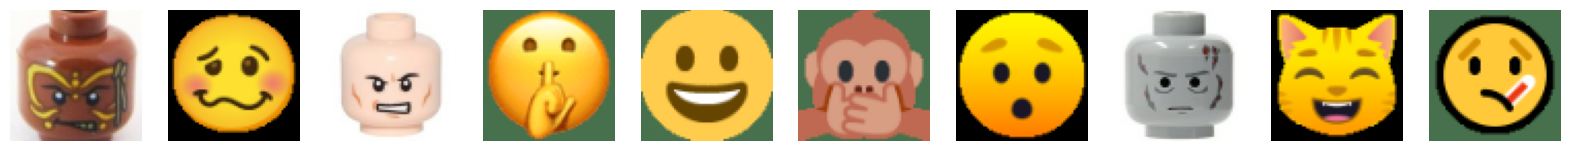

Reconstructions


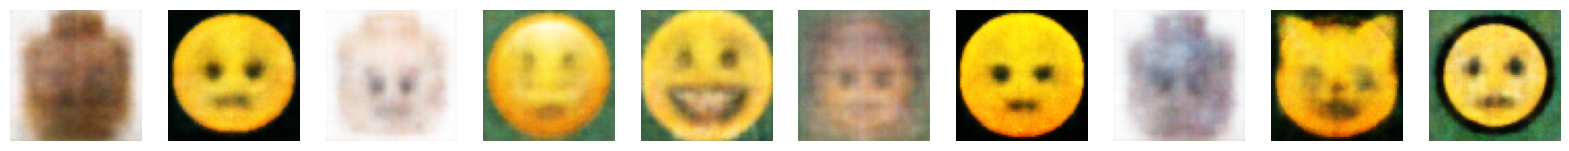

In [21]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real faces")
display(example_images)
print("Reconstructions")
display(reconstructions)

## 4. Latent space distribution

16/16 [==============================] - 0s 3ms/step


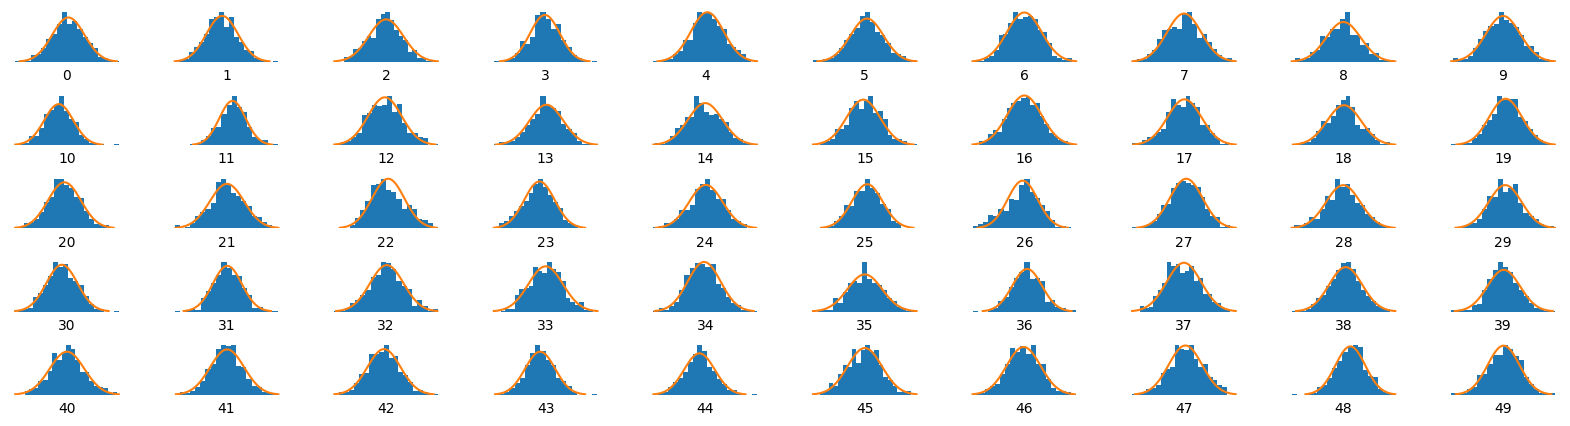

In [22]:
_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

## 5. Generate new faces <a name="decode"></a>

In [23]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [24]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 422ms/step


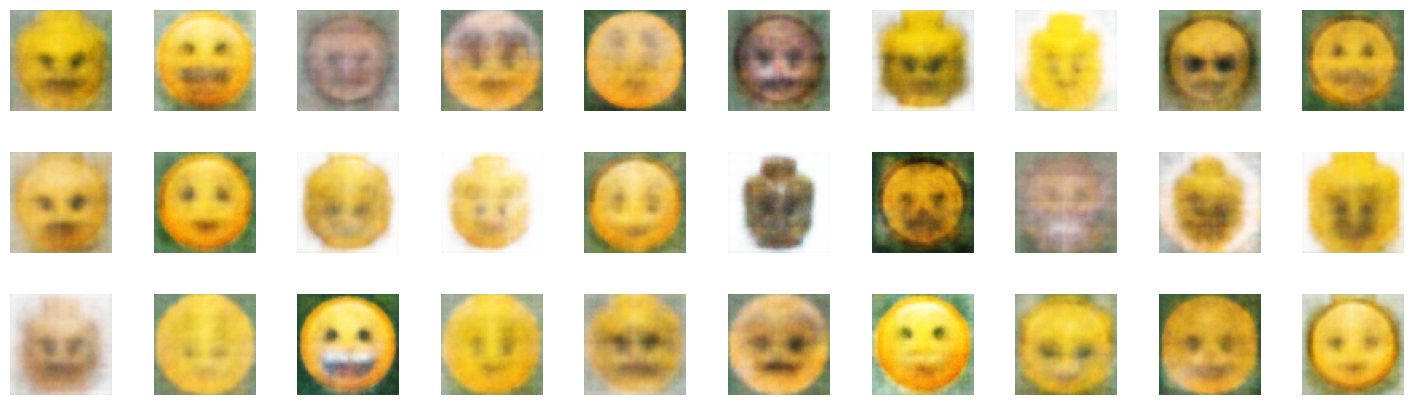

In [25]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])

## 6. Manipulate the images <a name="manipulate"></a>

In [26]:
from unicodedata import name
# Load the face data with label attached
LABEL = np.zeros(1994)
#LABEL = "Blond_Hair"  # <- Set this label
labelled_test = utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Datasets/lego_emoji/lego+emoji",
    labels=list(LABEL),
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)

labelled = labelled_test.map(lambda x, y: (preprocess(x), y))

Found 1994 files belonging to 1 classes.
Using 398 files for validation.


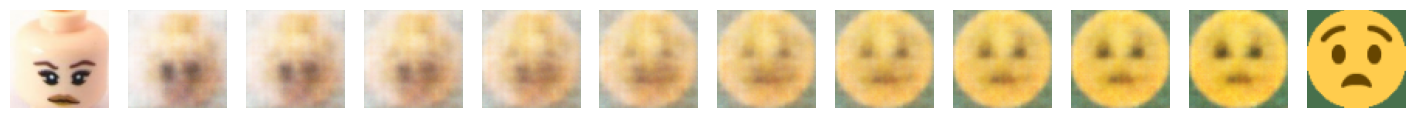

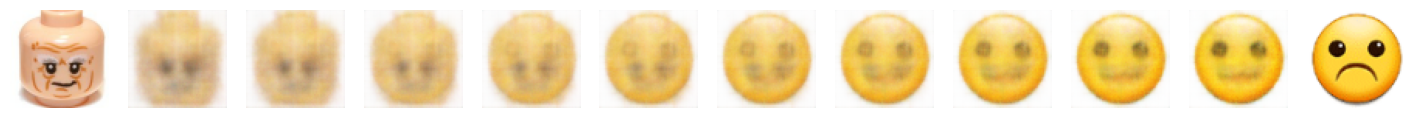

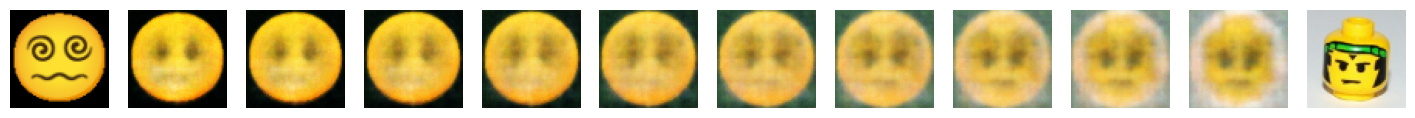

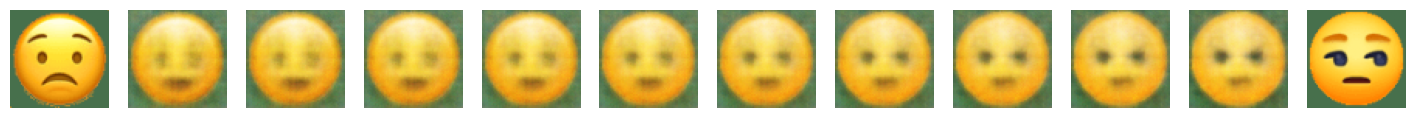

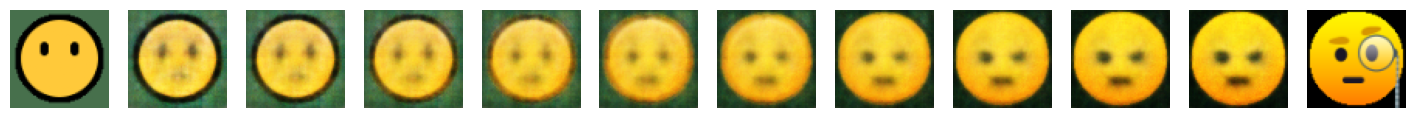

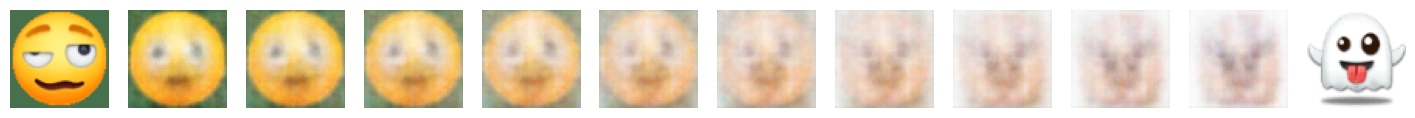

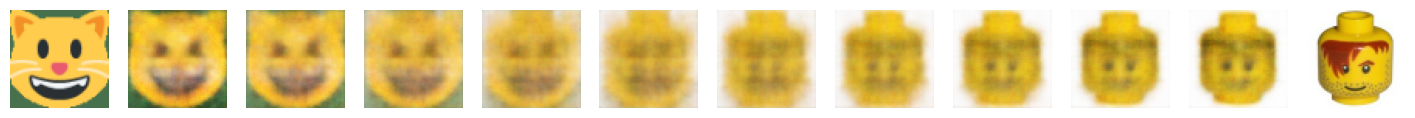

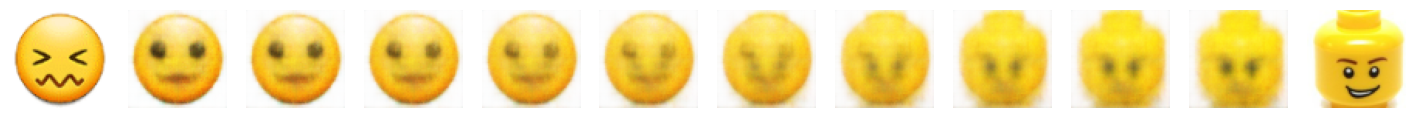

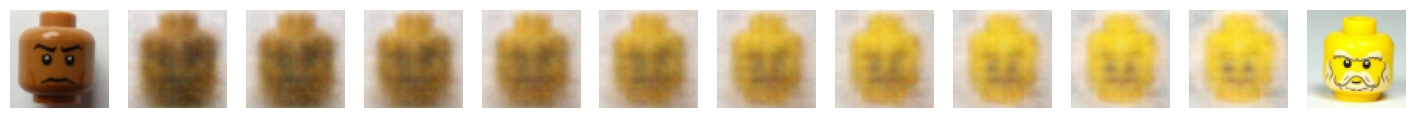

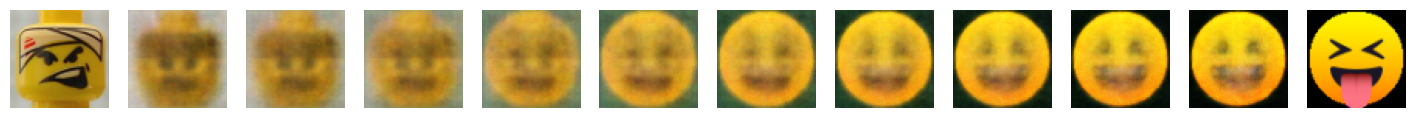

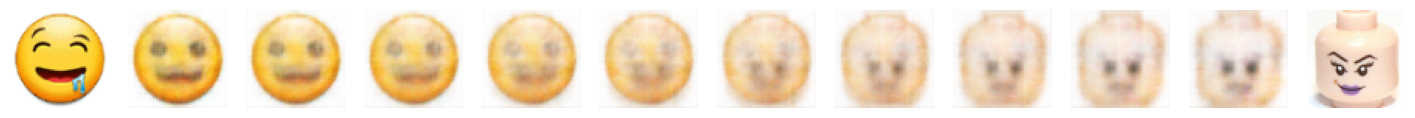

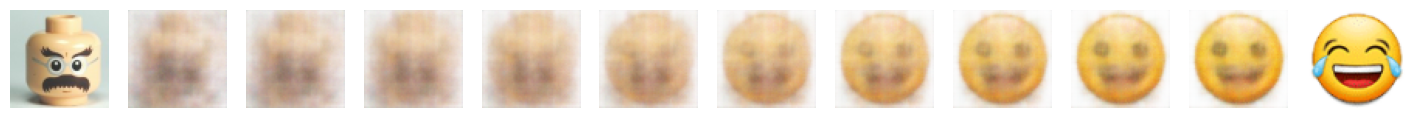

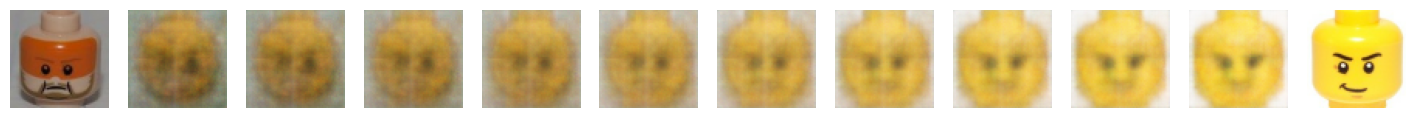

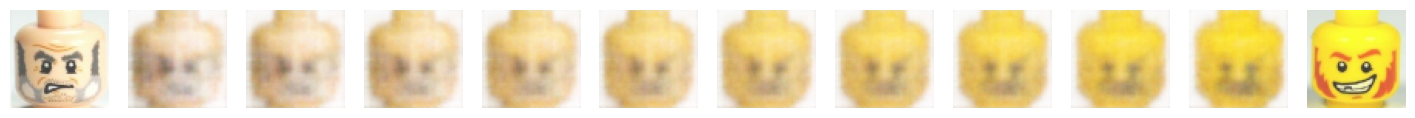

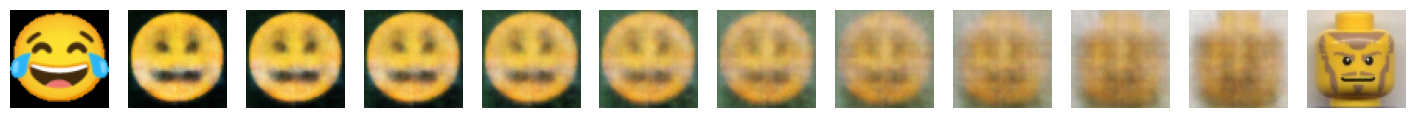

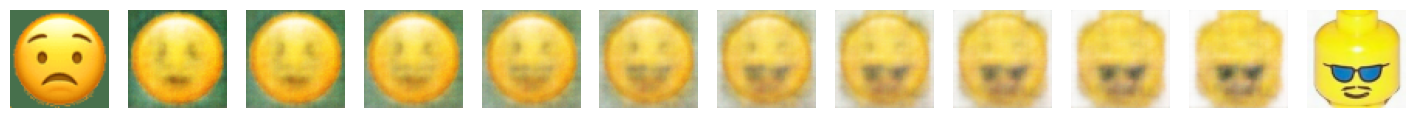

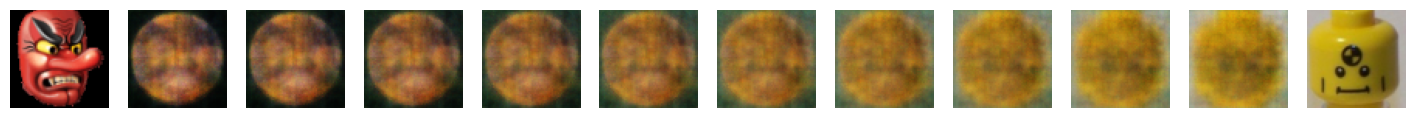

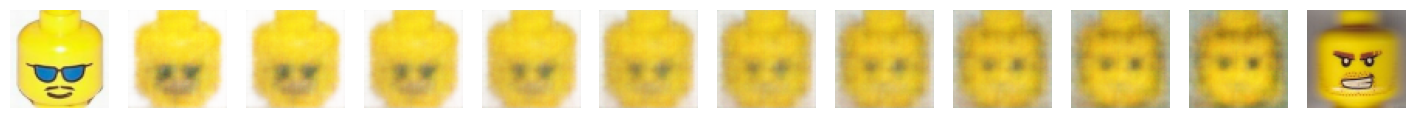

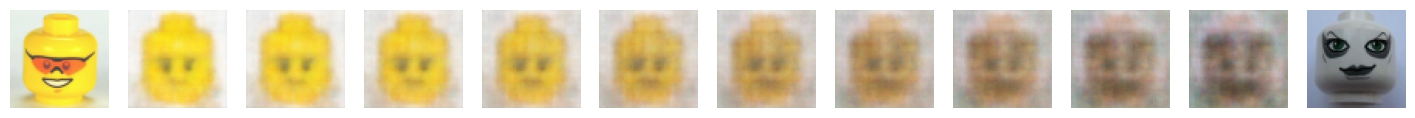

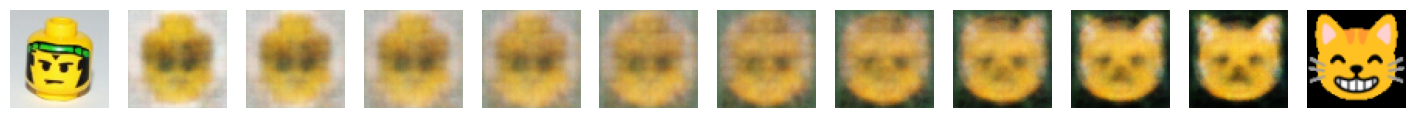

In [27]:
for i in range(20):
  morph_faces(labelled, vae)